## Packages


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import requests
import zipfile
import pathlib
from pathlib import Path
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
# set up device agnostic code:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Downloading a custom dataset

In [ ]:
# set up path to data folder:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory aleardy exists")
else:
  print(f"{image_path} does not exist, creating one ...")
  image_path.mkdir(parents=True, exist_ok=True)


# download the zip file of the data:
with open(data_path / "pizza_steak_susshi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)


# unzip the data in image_path:
with zipfile.ZipFile(data_path / "pizza_steak_susshi.zip", "r") as zip_ref:
  print("Unzipping data.........")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory aleardy exists
Unzipping data.........


In [ ]:
## setup train and testing image path:
train_dir = image_path / "train"
test_dir = image_path / "test"

### 1.1 Exploring the data format

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


### 1.2 Visualizing a random image

In [ ]:
# get all the image paths:
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [ ]:
# set the seed:
random.seed(42)
# pick a random path:
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_steak_sushi/train/steak/3857508.jpg')

In [ ]:
# get the image class:
image_class = random_image_path.parent.stem
print(image_class)

steak


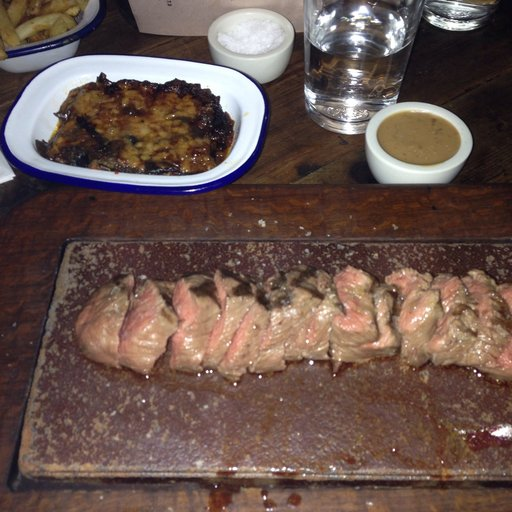

In [ ]:
# show the image:
img = Image.open(random_image_path)
img

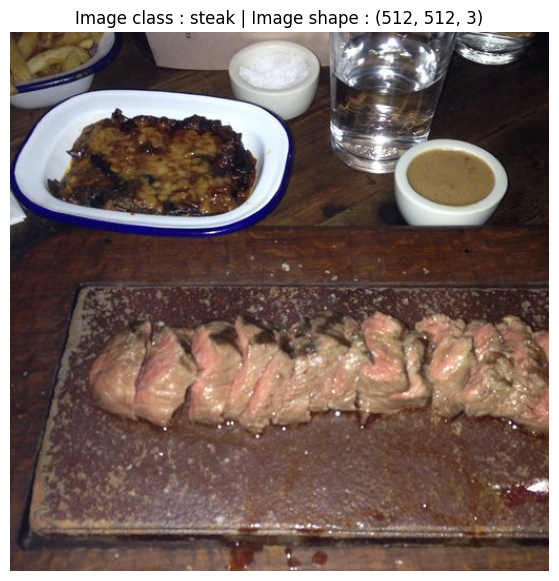

In [ ]:
# turn the image into an array:
img_as_array = np.asarray(img)
# plot the imge with matplotlib:
plt.figure(figsize=(10, 7));
plt.imshow(img_as_array);
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape}")
plt.axis(False);

## 2. Transforming data

### 2.1 Turning data into tensors

In [ ]:
# transforming data with torchvision.transforms:
data_transform = transforms.Compose([
    # Reseize our images to 64*64:
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizental:
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
# apply transform to an example:
transformed_img = data_transform(img)
print(f"Type : {type(transformed_img)} | Shape : {transformed_img.shape}")

Type : <class 'torch.Tensor'> | Shape : torch.Size([3, 64, 64])


### 2.2 Visualizing transformed images

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize : {f.size}")
      ax[0].axis(False)

      transformed_f = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_f)
      ax[1].set_title(f"Transformed\nShape : {transformed_f.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class : {image_path.parent.stem}")

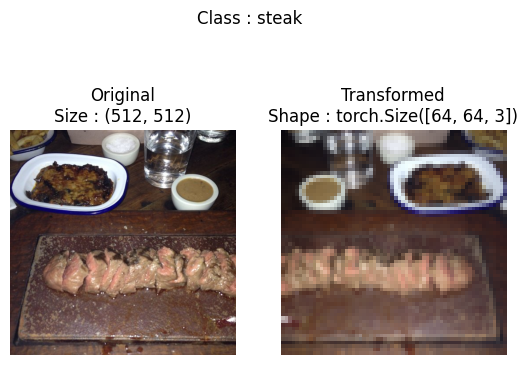

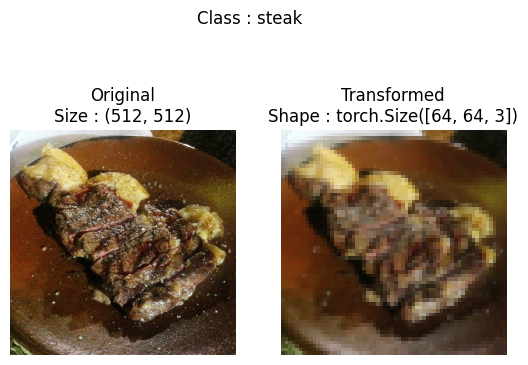

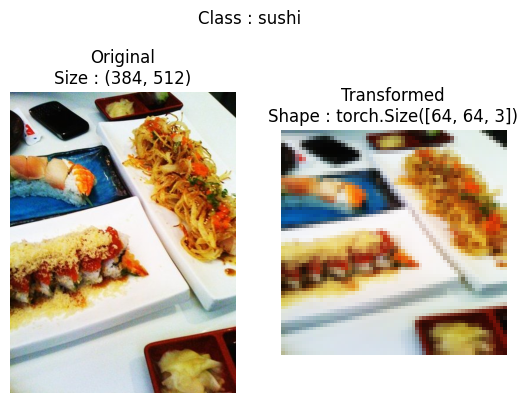

In [ ]:
plot_transformed_images(image_path_list, data_transform)

### 2.3 Loading image data using ImageFolder

In [ ]:
# Use ImageFolder:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [ ]:
# get class names:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# get class : id dicy:
class_idx = train_data.class_to_idx
class_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# check the length of the data:
len(train_data), len(test_data)

(225, 75)

In [ ]:
# check the first sample:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

### 2.4 Visualizing a loaded image from the train dataset

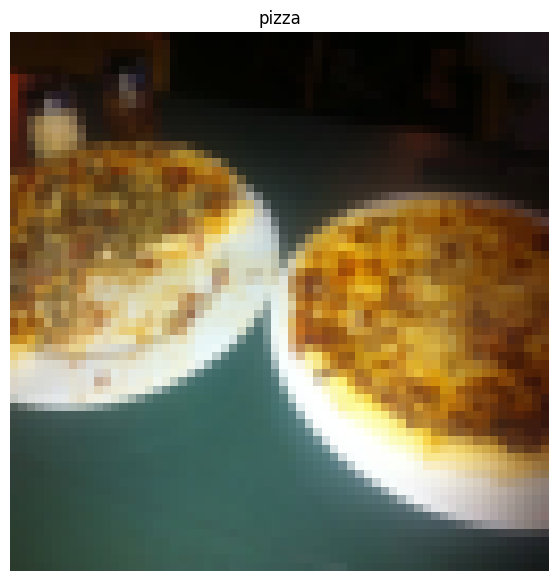

In [ ]:
img = train_data[0][0]
label = train_data[0][1]
# rearrange the shape:
img_permute = img.permute(1, 2, 0)
# plot the image:
plt.figure(figsize=(10, 7));
plt.imshow(img_permute);
plt.axis("off");
plt.title(class_names[label]);


### 2.5 Turning our image datasets into dataloader

In [ ]:
# turn or train/test data into dataloader:
BATCH_SIZE = 1

# train dataloader:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

# test dataloader:
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79a9276ce270>,
 <torch.utils.data.dataloader.DataLoader at 0x79a9276b5970>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
train_dataloader

## 3. Creating a custom dataset class

### 3.1 Creating a helper function to get class names from a directory

In [ ]:
# get the class names from the target directory:
target_directory = train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory):
  # 1. Get the class names by scanning the target directory:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found:
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  # 3. create a dictionnary of index labels :
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}

  return classes, class_to_idx


In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 3.2 Writing a custom dataset from scratch

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as a transform if we 'd like to transform our data.
3. Create several attributes:
   * paths - paths of our images
   * transform - the transform we would like to use
   * classes - a list of the target classes
   * class_to_idx - a dict of the target classes mapped to integr labels
4. create a function to `load_images()`, this function will open an image
5. overwrite the `__len()__` to return the length of our dataset
6. overwrite `__getitem()__` to return a given sample when passed an index

In [ ]:
# write a custom dataset:
class ImageFolderCustom(Dataset):
  # 1. Initialize the custom dataset:
  def __init__(self, targ_dir, transform=None):

    # 2. create class attributes:
    # Get all the image paths:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform:
    self.transform = transform
    # creata classes and classes_idx attributes:
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 3. create a function to load images:
  def load_image(self, index):
    "Opens an image via a pth and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 4. the length of the data:
  def __len__(self):
    "returns the total number of samples"
    return len(self.paths)

  # 5. ovveride the __getitem__() function:
  def __getitem__(self, index):
    "Returns one sample of data (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [ ]:
# create a transform:
train_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()])

In [ ]:
# create an instance of our custom dataset:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [ ]:
# get the classes names:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 3.3 Create a function to visualize random images

In [ ]:
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):

  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes n shouldn't be larger than 10")

  if seed:
    random.seed(seed)

  # get random sample indexes:
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  # loop through the sample images indexes:
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


For display purposes n shouldn't be larger than 10


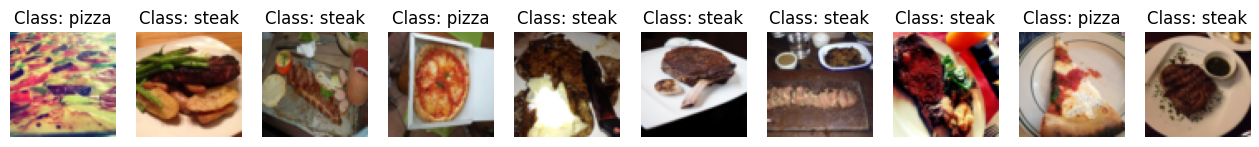

In [ ]:
display_random_images(train_data_custom, n=20, classes=class_names, seed=42)

### 3.4 Turning data into dataloaders

In [ ]:
# train dataloader:
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

# test dataloader:
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

In [ ]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x79a924bd3f50>,
 <torch.utils.data.dataloader.DataLoader at 0x79a9266388c0>)

In [ ]:
# print a sample:
img_custom, label_custom = next(iter(train_dataloader_custom))
# print the shape:
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 4. Data augmenatation

In [ ]:
# Let's try trivial augmentation:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

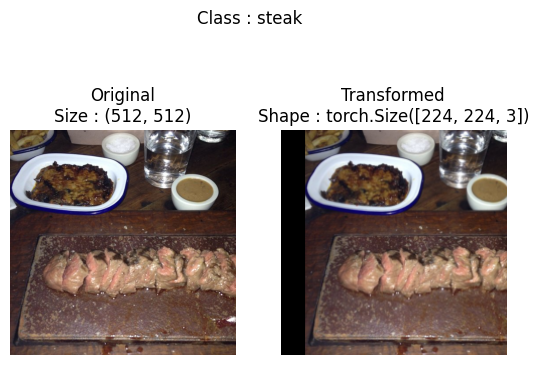

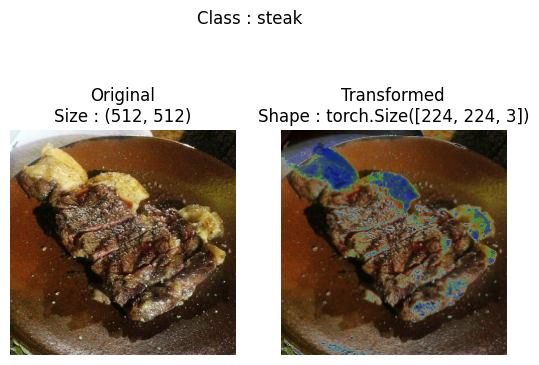

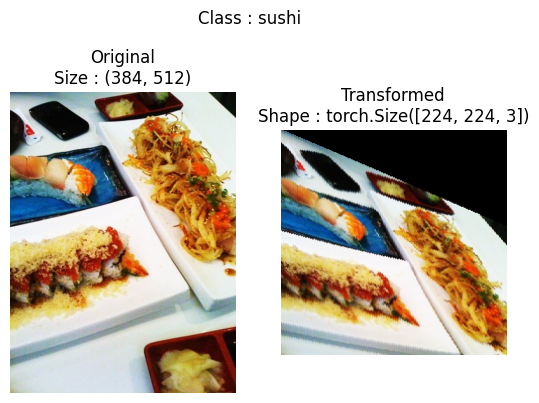

In [ ]:
# plot random images:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3)

## 5. Model 0: Tiny VGG without data augmentation

### 5.1 Creating a simple dataset

In [ ]:
# create a simple transforms:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# create a dataset:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [ ]:
# turn data into  dataloader:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

### 5.2 Replicate a tiny VGG:


In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 5.3 Try a forward pass on a single image ( to test the model )

In [ ]:
# get a single image batch
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# try a forward pass:
result = model_0(img_batch)
result.shape

torch.Size([32, 3])

### 5.4 Training/Testing loops

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc




### 5.5 Train function

In [ ]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 5.6 Train and evaluate model

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1343 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 17.930 seconds


### 5.7 Plotting the loss curves of model

In [ ]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_loss")
  plt.plot(epochs, test_accuracy, label="test_loss")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



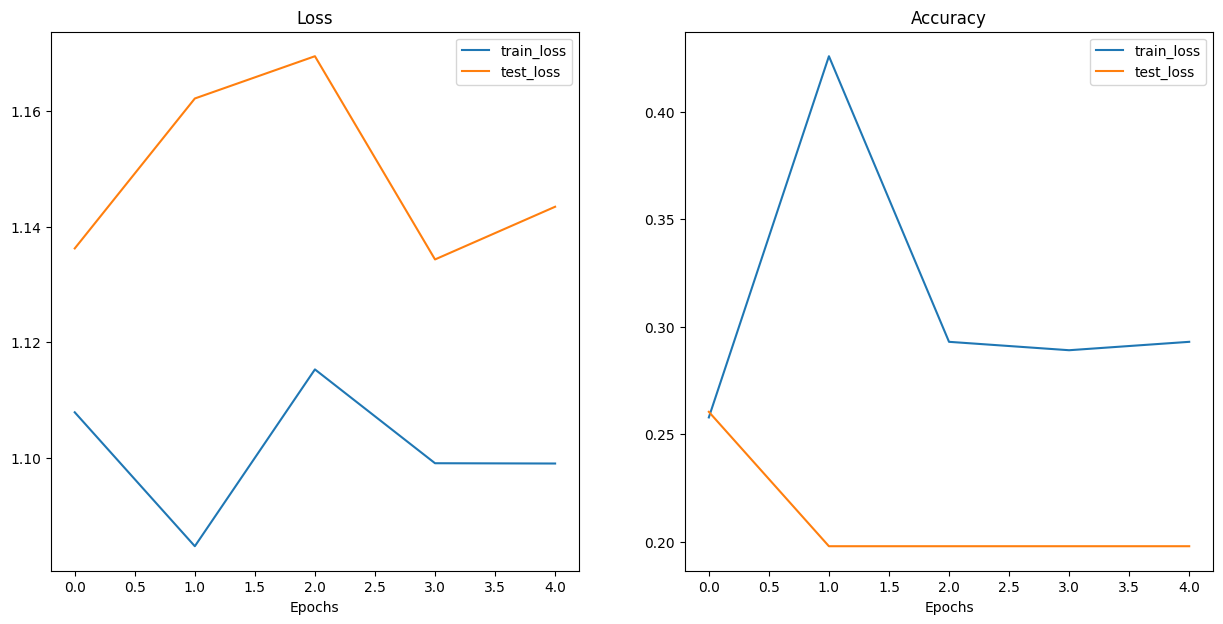

In [ ]:
plot_loss_curves(model_0_results)

## 6. Model 1 : TinyVGG wit data augmentation

### 6.1 Creating augmented training datasets and dataloaders

In [ ]:
train_transform_trivial = transforms.Compose([
   transforms.Resize(size=(64, 64)),
   transforms.TrivialAugmentWide(num_magnitude_bins=31),
   transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# train dataset:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform_simple)

In [ ]:
# dataloader:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

### 6.2 Constructing and training model 1

In [ ]:
# create a model:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# train the model:
torch.manual_seed(42)
NUM_EPOCHS = 5

# loss function:
loss_fn = nn.CrossEntropyLoss()

# optimizer:
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# start time:
start_time = timer()

# training:
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end time:
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0899 | train_acc: 0.4258 | test_loss: 1.1482 | test_acc: 0.2604
Total training time: 9.218 seconds


### 6.3 Plotting the loss curves of model 1

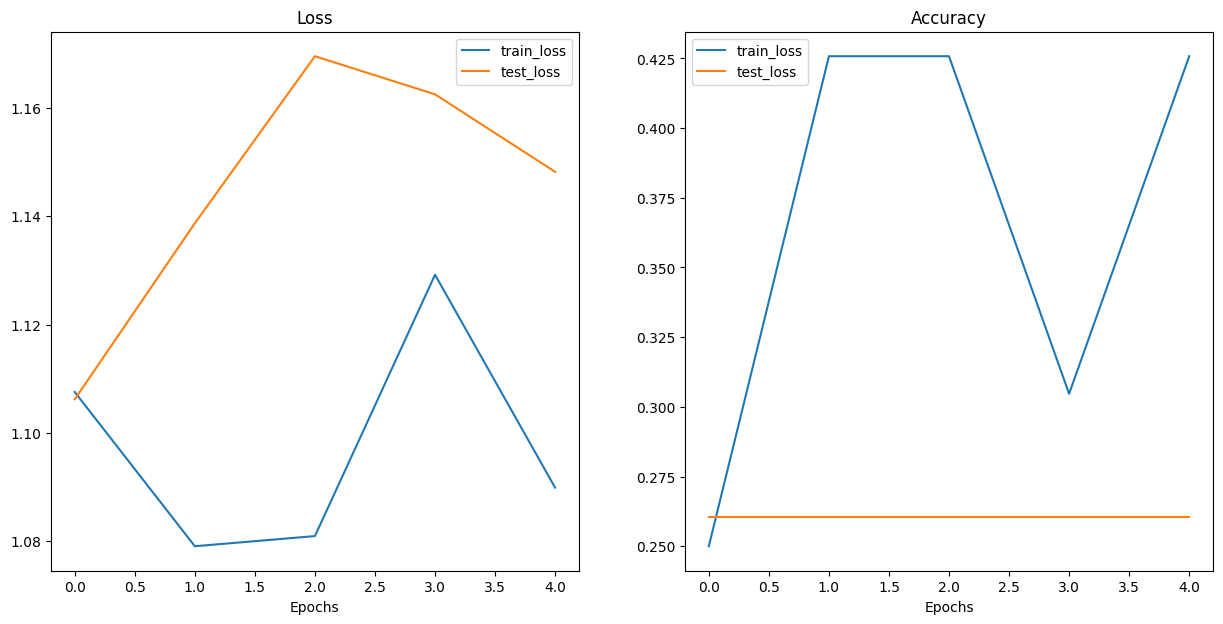

In [ ]:
plot_loss_curves(model_1_results)